# Computer Vision

## Task 1

Давай загрузим датасет CIFAR-10. Допиши функцию [load_dataloaders](./code-samples/cv_utils.py) с помощью [torchvision.datasets.CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
и [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), чтобы функция возвращала
DataLoaderы для train и test частей датасета. \
C помощью функции `len` количество батчей в train_loader и test_loader.
> Для DataLoader параметры `transform` и `batch_size` оставьте по умолчанию.

In [ ]:
! pip install torch
! pip install torchvision

In [1]:
import sys
sys.path.append('../code-samples')
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from cv_utils import imshow, Trainer, plot_train_log, load_dataloaders

In [2]:
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64 # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [34]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

In [3]:
train_loader, test_loader = load_dataloaders()
len(train_loader), len(test_loader)

Files already downloaded and verified
Files already downloaded and verified


(782, 157)

## Task 2

Узнай, как из объекта DataLoader можно получить изображения и метки. \
Передай первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow](./code-samples/cv_utils.py).
С помощью нее можно визуализировать датасет. \
Должна получиться примерно такая визуализация.
![sample](../misc/images/images_sample.png)
> Картинки и метки могут отличаться. Главное чтобы метки сходились с изображениями)

In [21]:
def imshow(images, labels, padding_size=15, labels_split_size=25):
    # убрать нормализацию
    img = img / 2 + 0.5    
    npimg = img.numpy()
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

            cat            ship            ship            plane


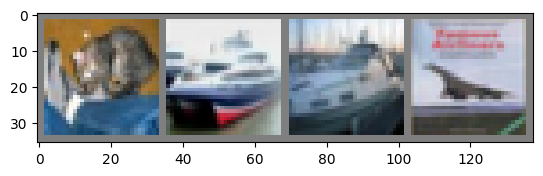

In [7]:
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images[:4]), labels[:4],  padding_size=12, labels_split_size=12)

## Task 3

Теперь попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Residual-Block. Схема этого блока приведена ниже:

<img src="../misc/images/rediual_block.png" width="500"/>

Допишите класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться: 
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [9]:
class ResidualNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_3 = nn.Conv2d(3, 32, 1)

        self.residual_block = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
        )

        self.clf = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):

        out = self.residual_block(x)
        out += self.conv_3(x)
        out = self.clf(out)

        return out

In [10]:
# Smotrim stryctyry seti
net = ResidualNet()
net

ResidualNet(
  (conv_3): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (residual_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (clf): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [11]:
# Proverka seti
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## Task 4

Перейдем к обучению сети. В этом вам поможет класс [Trainer](./code-samples/cv_utils.py).\
Для обучения кроме самой модели 
требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучите сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [11]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)
        
        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader):
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs):
        
        self.train_loss_log = [] 
        self.train_acc_log = [] 
        self.test_loss_log = []
        self.test_acc_log = []
        
        for epoch in range(n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")
    
    def test(self, test_loader):
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

In [12]:
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) + 1), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

Сеть загружена на cuda:0
Epoch 0
 train loss: 62.87802693423103, train acc: 0.6648217710997443
 test loss: 64.74230286422049, test acc: 0.65734474522293

Epoch 1
 train loss: 58.241594675556776, train acc: 0.6887787723785166
 test loss: 68.64915008909384, test acc: 0.6309713375796179

Epoch 2
 train loss: 56.32088240821038, train acc: 0.7008671675191815
 test loss: 59.53564713714989, test acc: 0.6782444267515924

Epoch 3
 train loss: 55.37896338265266, train acc: 0.7022458439897699
 test loss: 58.489134679174725, test acc: 0.681827229299363

Epoch 4
 train loss: 54.37549737286385, train acc: 0.7110174232736572
 test loss: 56.33878577894466, test acc: 0.6979498407643312



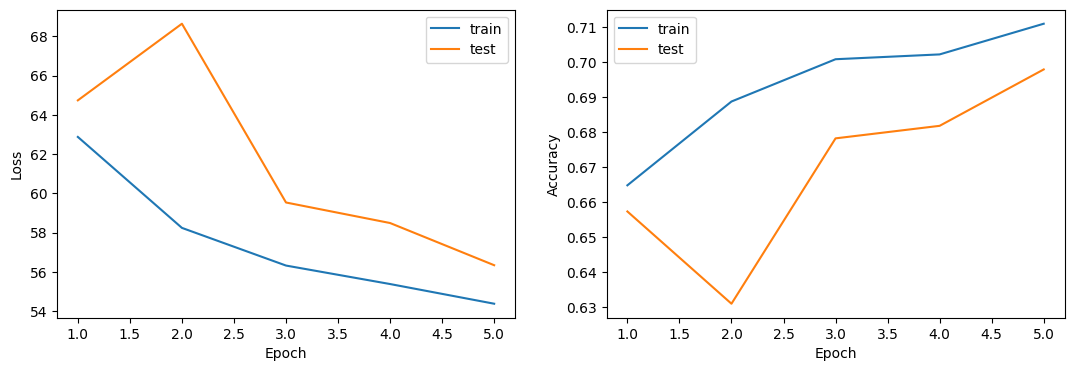

In [21]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

trains = Trainer(net, optimizer, criterion)
trains.train(train_loader, test_loader, 5)
plot_train_log(trains)

## Task 5

Одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. \
Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки,  тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.
Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке `transforms`, который затем передается в Dataloader.\
Изучи, какие [способы аугментаций](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) 
изображений можно использовать PyTorch. Выберите несколько из них и визуализируйте как изменился датасет. 
![sample](../misc/images/images_sample.png)
![sample](../misc/images/augment.png)

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [11]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

Files already downloaded and verified
Files already downloaded and verified
            cat            ship            ship            plane


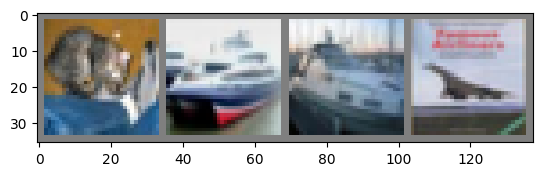

In [15]:
# izmenenni po RandomHorizontalFlip Dataset
train_loader, test_loader = load_dataloaders(
    transforms.Compose([transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images[:4]), labels[:4],  padding_size=12, labels_split_size=12)

Files already downloaded and verified
Files already downloaded and verified
            cat            ship            ship            plane


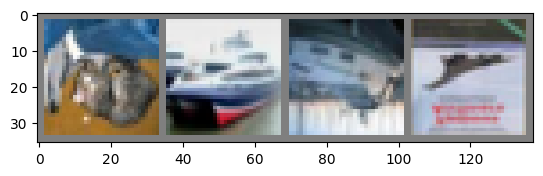

In [17]:
# izmenenni po RandomVerticalFlip Dataset
train_loader, test_loader = load_dataloaders(
    transforms.Compose([transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images[:4]), labels[:4],  padding_size=12, labels_split_size=12)

Files already downloaded and verified
Files already downloaded and verified
            cat            ship            ship            plane


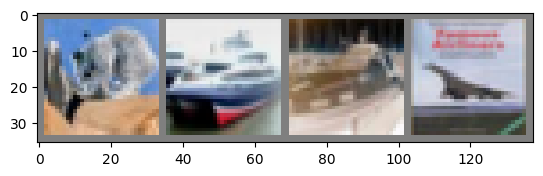

In [18]:
# izmenenni po RandomInvert Dataset
train_loader, test_loader = load_dataloaders(
    transforms.Compose([transforms.RandomInvert(),
                        transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images[:4]), labels[:4],  padding_size=12, labels_split_size=12)

Files already downloaded and verified
Files already downloaded and verified
            cat            ship            ship            plane


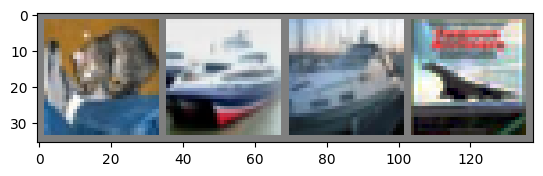

In [22]:
# izmenenni po RandomEqualize Dataset
train_loader, test_loader = load_dataloaders(
    transforms.Compose([transforms.RandomEqualize(),
                        transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images[:4]), labels[:4],  padding_size=12, labels_split_size=12)

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = net.to(device)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        CLASSES[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 78 %
Accuracy of  bird : 32 %
Accuracy of   cat : 64 %
Accuracy of  deer : 56 %
Accuracy of   dog : 45 %
Accuracy of  frog : 58 %
Accuracy of horse : 76 %
Accuracy of  ship : 75 %
Accuracy of truck : 83 %
